In [27]:
import pandas as pd
import datetime

def daily_summary(ticker):

    # Data Preprocessing
    filename = "../data/" + ticker + "_1min_firstratedata.csv"
    df = pd.read_csv(filename)
    df["ticker"] = ticker

    # time handling
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["date"] = df["timestamp"].dt.date
    df["time"] = df["timestamp"].dt.time
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
    
    # Crop to market hours
    df = df[(df["time"] >= datetime.time(9, 30)) & (df["time"] <= datetime.time(16, 0))]

    # Get the earliest and latest times for each day
    # Find the indices of the earliest and latest rows for each day
    earliest_indices = df.groupby("date")["time"].idxmin()
    latest_indices = df.groupby("date")["time"].idxmax()

    # Concatenate the indices and drop duplicates
    indices_to_keep = pd.concat([earliest_indices, latest_indices]).drop_duplicates()

    # Create a new DataFrame with only the selected rows
    df = df.loc[indices_to_keep]
    df = df.sort_values(by=["date"])
    df.drop(["timestamp", "high", "low"], axis=1, inplace=True)

    df = df.groupby(["date", "time"]).filter(lambda group: len(group) != 2)
    
    open_rows = df[df["time"] == datetime.time(9, 30)][["date", "open", "time"]]
    close_rows = df[df["time"] == datetime.time(16, 0)][["date", "close", "time"]]

    merged_df = pd.merge(open_rows, close_rows, on=["date"])
    merged_df["dif"] = merged_df["close"] - merged_df["open"]
    merged_df["dif"] = merged_df["dif"].round(2)

    merged_df["percent_change"] = (merged_df["dif"] / merged_df["open"]).round(2)
    merged_df["percent_change"] = merged_df["percent_change"] * 100

    merged_df["up"] = merged_df["dif"] > 0
    merged_df["up"] = merged_df["up"].astype(int)

    merged_df.to_csv("../temp/merged.csv", index=False)

    return merged_df

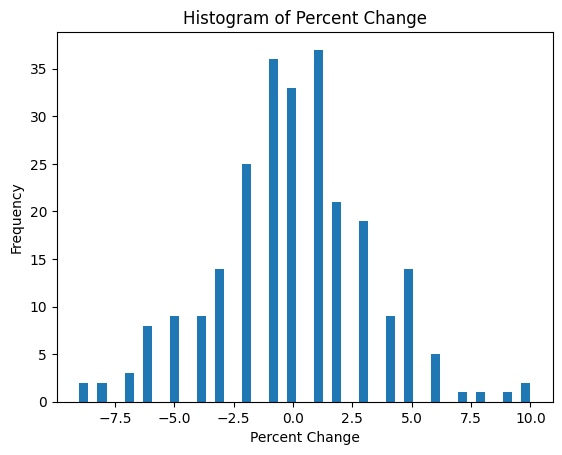

In [28]:
# chart a histogram of the daily percent change

import matplotlib.pyplot as plt
import numpy as np

merged_df = daily_summary("TSLA")

plt.hist(merged_df["percent_change"], bins=50)
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.title("Histogram of Percent Change")
plt.show()